<a href="https://colab.research.google.com/github/glenroger19/Calcul-de-plaque-polycarbonate/blob/main/Satisfaction_client_iteration9_textmining_Etape_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import re

In [5]:
# importation du DATASET 
from google.colab import files

uploaded = files.upload()


Saving reviews_trust.csv to reviews_trust.csv


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


1    0.58828
0    0.41172
Name: Sentiment, dtype: float64

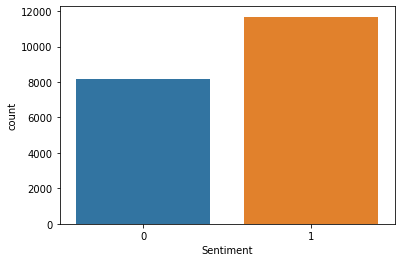

In [6]:
df = pd.read_csv("reviews_trust.csv")
df = df[["Commentaire", "star"]]
df["Sentiment"] = df["star"].apply(lambda x : np.where(x >=4 , 1 , 0))  # ajout de la colonne Sentiment à df
sns.countplot(df.Sentiment);
df["Sentiment"].value_counts(normalize = True) # léger déséquilibre des classes mais peut être traité comme un problème non déséquilibré

In [7]:
#Suppression des valeurs manquantes de la colonne Commentaire
df = df.dropna(axis = 0, how = 'any', subset =["Commentaire"])
df.reset_index(inplace = True)
df = df.drop(['index','star'],axis = 1)

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
#Nettoyages des commentaires et étapes de normalisation 

def find_exclamation(com):   #compte le nombre de points d'exclamation d'un commentaire
    r = re.compile(r"\!")
    exclamation = r.findall(com)
    return len(exclamation)

def find_interogation(com): #compte le nombre de points d'interogation d'un commentaire
    r = re.compile(r"\?")
    interogation = r.findall(com)
    return len(interogation)

def findCAPSLOCK(com):  #compte le nombre de caractères en majuscule d'un commentaire
    r = re.compile(r"[A-Z]")
    capslock = r.findall(com)
    return len(capslock)

def find_etc(com): #compte le nombre de chaine de ".." d'un commentaire
    r = re.compile(r"\.{2,}")
    etc = r.findall(com)
    return len(etc)

df["CAPSLOCK"]= df["Commentaire"].apply(lambda x : findCAPSLOCK(x))
df["exclamation"]= df["Commentaire"].apply(lambda x : find_exclamation(x))
df["interogation"]= df["Commentaire"].apply(lambda x : find_interogation(x))
df["chainpoints"]= df["Commentaire"].apply(lambda x : find_etc(x))
df['nb_caracter'] = df["Commentaire"].apply(len)
#traitement des emojis
# import emoji
# def extract_smiley(s):
#     r = re.compile(r":[A-Za-z0-9_]+:")
#     smiley = r.findall(emoji.demojize(s))
#     return " ".join(smiley)

# df["emoji"]= df["Commentaire"].apply(lambda x : extract_smiley(x))

# df["emoji"] = df["emoji"].replace("",0)

# # reduction de la liste de smiley (suppression des doublons dans chaque phrases)
# liste_col_emoji = []
# for row in df["emoji"]:
#     liste_col_emoji.append(str(row))
# print(len(liste_col_emoji))

# def extract_emoji_unique(liste_col_emoji):
#     emoji_liste = []
#     for emoji in liste_col_emoji :
#         emoji_unique = []
#         emoji = emoji.split()
#         for el in emoji :
#             if el not in emoji_unique: 
#                 emoji_unique.append(el)
#         emoji_liste.append(" ".join(emoji_unique))
#     return emoji_liste
    
# emoji_sans_rep = extract_emoji_unique(liste_col_emoji)
# emoji_cleaned = pd.DataFrame(emoji_sans_rep, columns=["cleaned_emoji"])
# df = pd.concat([df,emoji_cleaned], axis= 1)
# emoji = pd.get_dummies(df["cleaned_emoji"])
# df = pd.concat([df,emoji], 1)
# df = df.drop(["emoji",":02: :03:"], axis = 1)

#Tokenization via RegexpTokenizer

from nltk.tokenize.regexp import RegexpTokenizer
tokenizer = RegexpTokenizer("[a-zA-Z0-9éèê_]{1,}")
df["preprocessed"] = df["Commentaire"].apply(lambda x : " ".join(x.lower() for x in str(x).strip().split()))

# On remplace les éèê par e
def remplacement_carac_e(com):
    text=re.sub(r"[éèêë]","e",com)
    return text
df["preprocessed"] = df["preprocessed"].apply(lambda x : remplacement_carac_e(x))

def neg_identify(text): 
    text = tokenizer.tokenize(text)
    for pos, word in enumerate(text) :
        if pos != len(text)-1 :
            if (word == 'ne' or word == "n" or word =="n'"):
                text[pos+1] = "NON_"+text[pos+1]
    text = " ".join(text)
    return (text)
df["preprocessed"] = df["preprocessed"].apply(lambda x : neg_identify(x))

# Déclaration des stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('french'))
stop_words.update (["?","!","_",".",":",",",";","-","--","...","'","...","'",',',',','…la','la','le','les','..','…','(',')','a+','+','etc…','qq','``',"j'","j '"])
# après une première visualisation des données, "commande" est très freqement apparu dans les 2 catégories et n'apporte à priori pas d'information sur la satisfaction du client"
# print(stop_words)

# Definition d'une fonction de filtrage de stopwords
def stopwords_filtering(chaine): # fonction renvoyant une liste ne contenant pas les stopwords
    tokens =[]
    chaine = tokenizer.tokenize(chaine)
    for mot in chaine :
        if mot not in stop_words :#conservation des mots non stopwords 
            tokens.append(mot)
    tokens = " ".join(tokens)
    return tokens
df["preprocessed"] = df["preprocessed"].apply(lambda x : stopwords_filtering(x))

# Opération de stemming

from nltk.stem.snowball import FrenchStemmer

stemmer = FrenchStemmer()
def  stemming(text) :
    text = tokenizer.tokenize(text)
    stemmed_text = ""
    for mot in text: 
        stem = stemmer.stem(mot)
        stemmed_text =  stemmed_text +" "+ stem
    return  stemmed_text

df["preprocessed"] = df["preprocessed"].apply(lambda x: stemming(x))


In [10]:
df

,Commentaire,Sentiment,CAPSLOCK,exclamation,interogation,chainpoints,nb_caracter,preprocessed
0,"Bonjour , Ca doit faire 5 ans environ que je s...",0,18,21,2,1,1182,bonjour ca doit fair 5 an environ membr showr...
1,Vente lacoste article manquant photo prise sur...,0,2,0,0,0,138,vent lacost articl manqu photo pris 6 articl ...
2,"Vente Lacoste Honteuse , article erroné , arti...",0,15,1,0,0,1191,vent lacost honteux articl erron articl manqu...
3,J'ai commandé des mules de la marque Moosefiel...,0,3,2,0,0,148,command mul marqu moosefield tre ue produit e...
4,Commande téléphone etat A+ . Livraison d un vi...,0,9,6,0,0,272,command telephon etat a livraison vieux telep...
...,...,...,...,...,...,...,...,...
19829,Pas de probleme,1,1,0,0,0,15,problem
19830,Cliente depuis 2008 sans encombre jusqu ' à ju...,0,36,4,0,4,875,client depuis 2008 san encombr jusqu juin 201...
19831,Je ne sais pas si VP cherche à vendre ou à fai...,0,20,1,1,6,718,non_s si vp cherch vendr fair fuir client col...
19832,Je suis client sur ce site depuis plusieurs an...,1,5,0,0,0,436,client sit depuis plusieur anne dois avou ret...


#Analyse de sentiments ##

### Methode BOW (Bag of words) CountVectorizer

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split 

X = df.drop(['Commentaire', 'Sentiment'], axis=1)
y = df["Sentiment"]
df_train, df_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB #Particulièrement adapté aux problèmes de classification avec des features discretes (text classification)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

##  Algorithmes de classification sans tunning d'hyperparamètres
- Régression logistique
- SVM
- Naïve Bayes
- GradientBoosting
Vectorisation prenant en compte uniquement les unigrams (vectorisation mot / mot)

In [ ]:
%%time
from scipy.sparse import hstack
# Vectorization avec CountVectorizer ()

vec_unigram = CountVectorizer(analyzer='word', ngram_range=(1,1)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_unigram.fit_transform(df_train.preprocessed)
X_test_text = vec_unigram.transform(df_test.preprocessed)
#on ajoute les metadonnées à notre vecteur d'occurence
X_train = hstack((X_train_text, df_train.drop('preprocessed', axis=1).values))
X_test = hstack((X_test_text, df_test.drop('preprocessed', axis=1).values))

# instanciation des classifieurs 
clf_reglog_unigram = LogisticRegression(C=1, max_iter= 10000)
clf_svc_unigram = SVC()
clf_MNB_unigram = MultinomialNB() 
clf_GB_unigram = GradientBoostingClassifier()

# Fit des classifieurs aux données d'entraînement
clf_reglog_unigram.fit(X_train, y_train)
clf_svc_unigram.fit(X_train, y_train)
clf_MNB_unigram.fit(X_train, y_train)
clf_GB_unigram.fit(X_train, y_train)

CPU times: user 52.2 s, sys: 20 s, total: 1min 12s
Wall time: 57.9 s


In [ ]:
%%time
# Affichage des scores des différents classifieurs

print(" -- Régression logistique --")
print("Score sur le trainset :",clf_reglog_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_reglog_unigram.score(X_test,y_test))
print(" -- SVC --")
print("Score sur le trainset :",clf_svc_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_svc_unigram.score(X_test,y_test))
print(" -- Multinomial Naïve Bayes --")
print("Score sur le trainset :",clf_MNB_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_MNB_unigram.score(X_test,y_test))
print(" -- GradientBoosting -- ")
print("Score sur le trainset :",clf_GB_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_GB_unigram.score(X_test,y_test))

 -- Régression logistique --
Score sur le trainset : 0.9432785025524674 ; Score sur le testset :  0.8905974287874968
 -- SVC --
Score sur le trainset : 0.8157811810676247 ; Score sur le testset :  0.8124527350642803
 -- Multinomial Naïve Bayes --
Score sur le trainset : 0.8771034221970126 ; Score sur le testset :  0.8694227375850769
 -- GradientBoosting -- 
Score sur le trainset : 0.8733219890338438 ; Score sur le testset :  0.8653894630703303
CPU times: user 24.9 s, sys: 0 ns, total: 24.9 s
Wall time: 27.4 s


##   Tunning d'hyperparamètres des Algorithmes de classification
- Régression logistique
- SVM
- Naïve Bayes
- GradientBoosting
Vectorisation prenant en compte des ngrams (1 à 2)

In [ ]:
%%time
X = df.drop(['Commentaire', 'Sentiment'], axis=1)
y = df["Sentiment"]
df_train, df_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)

# Vectorization avec CountVectorizer ()

vec_ngram = CountVectorizer(analyzer='word', ngram_range=(1,2)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_ngram.fit_transform(df_train.preprocessed)
X_test_text = vec_ngram.transform(df_test.preprocessed)

#on ajoute les metadonnées à notre vecteur d'occurence
X_train = hstack((X_train_text, df_train.drop('preprocessed', axis=1).values))
X_test = hstack((X_test_text, df_test.drop('preprocessed', axis=1).values))

# instanciation des classifieurs 
clf_reglog_ngram = LogisticRegression(C=1, max_iter= 10000)
clf_svc_ngram = SVC()
clf_MNB_ngram = MultinomialNB() 
clf_GB_ngram = GradientBoostingClassifier() 

# Fit des classifieurs aux données d'entraînement
clf_reglog_ngram.fit(X_train, y_train)
clf_svc_ngram.fit(X_train, y_train)
clf_MNB_ngram.fit(X_train, y_train)
clf_GB_ngram.fit(X_train, y_train)

CPU times: user 2min 36s, sys: 1min 23s, total: 3min 59s
Wall time: 3min 31s


In [ ]:
%%time
# Affichage des scores des différents classifieurs
print(" -- Régression logistique --")
print("Score sur le trainset :",clf_reglog_ngram.score(X_train,y_train),"; Score sur le testset : ",clf_reglog_ngram.score(X_test,y_test))
print(" -- SVC --")
print("Score sur le trainset :",clf_svc_ngram.score(X_train,y_train),"; Score sur le testset : ",clf_svc_ngram.score(X_test,y_test))
print(" -- Multinomial Naïve Bayes --")
print("Score sur le trainset :",clf_MNB_ngram.score(X_train,y_train),"; Score sur le testset : ",clf_MNB_ngram.score(X_test,y_test))
print(" -- GradientBoosting -- ")
print("Score sur le trainset :",clf_GB_ngram.score(X_train,y_train),"; Score sur le testset : ",clf_GB_ngram.score(X_test,y_test))

 -- Régression logistique --
Score sur le trainset : 0.9851893867775887 ; Score sur le testset :  0.9037055709604235
 -- SVC --
Score sur le trainset : 0.8157181571815718 ; Score sur le testset :  0.8124527350642803
 -- Multinomial Naïve Bayes --
Score sur le trainset : 0.9069767441860465 ; Score sur le testset :  0.8389210990673053
 -- GradientBoosting -- 
Score sur le trainset : 0.8744564189827945 ; Score sur le testset :  0.8656415427275019
CPU times: user 36.4 s, sys: 0 ns, total: 36.4 s
Wall time: 37.1 s


In [ ]:
%%time
# Affichage des prédictions par les différents classifieurs
print(" -- Régression logistique --")
pred_clf_reglog_ngram = clf_reglog_ngram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_reglog_ngram,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_reglog_ngram))
print(" -- SVC --")
pred_clf_svc_ngram = clf_svc_ngram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_svc_ngram,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_svc_ngram))
print(" -- Multinomial Naïve Bayes --")
pred_clf_MNB_ngram = clf_MNB_ngram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_MNB_ngram,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_MNB_ngram))
print(" -- GradientBoosting -- ")
pred_clf_GB_ngram = clf_GB_ngram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_GB_ngram,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_GB_ngram))

 -- Régression logistique --


Classe réelle,0,1
Classe prédite,,
0,1416,236
1,146,2169


              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1652
           1       0.90      0.94      0.92      2315

    accuracy                           0.90      3967
   macro avg       0.90      0.90      0.90      3967
weighted avg       0.90      0.90      0.90      3967

 -- SVC --


Classe réelle,0,1
Classe prédite,,
0,1090,562
1,182,2133


              precision    recall  f1-score   support

           0       0.86      0.66      0.75      1652
           1       0.79      0.92      0.85      2315

    accuracy                           0.81      3967
   macro avg       0.82      0.79      0.80      3967
weighted avg       0.82      0.81      0.81      3967

 -- Multinomial Naïve Bayes --


Classe réelle,0,1
Classe prédite,,
0,1571,81
1,558,1757


              precision    recall  f1-score   support

           0       0.74      0.95      0.83      1652
           1       0.96      0.76      0.85      2315

    accuracy                           0.84      3967
   macro avg       0.85      0.85      0.84      3967
weighted avg       0.87      0.84      0.84      3967

 -- GradientBoosting -- 


Classe réelle,0,1
Classe prédite,,
0,1308,344
1,189,2126


              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1652
           1       0.86      0.92      0.89      2315

    accuracy                           0.87      3967
   macro avg       0.87      0.86      0.86      3967
weighted avg       0.87      0.87      0.86      3967

CPU times: user 6.42 s, sys: 0 ns, total: 6.42 s
Wall time: 6.43 s


### Mise au point du modèle Multinomial Naïve Bayes (prenant en compte uniquement des unigrams)

In [ ]:
%%time
from scipy.sparse import hstack
# Vectorization avec CountVectorizer ()

vec_unigram = CountVectorizer(analyzer='word', ngram_range=(1,1)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_unigram.fit_transform(df_train.preprocessed)
X_test_text = vec_unigram.transform(df_test.preprocessed)
#on ajoute les metadonnées à notre vecteur d'occurence
X_train = hstack((X_train_text, df_train.drop('preprocessed', axis=1).values))
X_test = hstack((X_test_text, df_test.drop('preprocessed', axis=1).values))

CPU times: user 415 ms, sys: 0 ns, total: 415 ms
Wall time: 413 ms


In [ ]:
from sklearn.model_selection import GridSearchCV
params = {"alpha": np.linspace(1e-10,1,20)}
grid_MN = GridSearchCV(MultinomialNB(), cv= 5, param_grid = params)
grid_MN.fit(X_train, y_train)
print("Meilleur paramètre : ", grid_MN.best_params_, "permettant d'obtenir un score de " , grid_MN.best_score_)
print("Score sur le trainset :",grid_MN.score(X_train,y_train),"; Score sur le testset : ",grid_MN.score(X_test,y_test))
print("On ne fait à priori pas face à un problème d'overfiting")

Meilleur paramètre :  {'alpha': 0.21052631586842105} permettant d'obtenir un score de  0.8644363447019006
Score sur le trainset : 0.8842251213209806 ; Score sur le testset :  0.8704310562137636
On ne fait à priori pas face à un problème d'overfiting


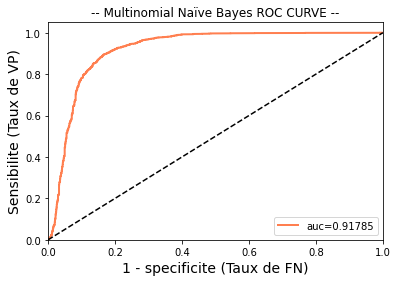

In [ ]:
y_pred_MNB = grid_MN.predict_proba(X_test)
from sklearn.metrics import auc, roc_curve

fpr , tpr , seuil = roc_curve(y_test, y_pred_MNB[:,1], pos_label= 1)
aucf= auc(fpr, tpr)

plt.plot(fpr, tpr, color='coral', lw=2, label ='auc=%1.5f' % aucf)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("-- Multinomial Naïve Bayes ROC CURVE --")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite (Taux de FN)', fontsize=14)
plt.ylabel('Sensibilite (Taux de VP)', fontsize=14)
plt.legend();
plt.show();


### Mise au point du modèle Multinomial Naïve Bayes (prenant en compte les  bigrams)

In [ ]:
%%time 

df_train, df_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)

# Vectorization avec CountVectorizer ()

vec_ngram = CountVectorizer(analyzer='word', ngram_range=(1,2)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_ngram.fit_transform(df_train.preprocessed)
X_test_text = vec_ngram.transform(df_test.preprocessed)

#on ajoute les metadonnées à notre vecteur d'occurence
X_train = hstack((X_train_text, df_train.drop('preprocessed', axis=1).values))
X_test = hstack((X_test_text, df_test.drop('preprocessed', axis=1).values))

params = {"alpha": np.linspace(1e-10,1,20)}
grid_MN_ngram = GridSearchCV(MultinomialNB(), cv= 5, param_grid = params)
grid_MN_ngram.fit(X_train, y_train)
print("Meilleur paramètre : ", grid_MN_ngram.best_params_, "permettant d'obtenir un score de " , grid_MN_ngram.best_score_)
print("Score sur le trainset :",grid_MN_ngram.score(X_train,y_train),"; Score sur le testset : ",grid_MN_ngram.score(X_test,y_test))
print("On fait probablement face à un problème d'overfiting")

Meilleur paramètre :  {'alpha': 0.4210526316368421} permettant d'obtenir un score de  0.8709910196520699
Score sur le trainset : 0.9418289531732527 ; Score sur le testset :  0.8764809679858835
On fait probablement face à un problème d'overfiting
CPU times: user 5.13 s, sys: 0 ns, total: 5.13 s
Wall time: 6.14 s


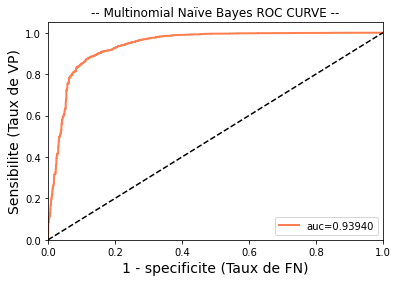

In [ ]:
y_pred_MNB_ngram = grid_MN_ngram.predict_proba(X_test)
from sklearn.metrics import auc, roc_curve

fpr , tpr , seuil = roc_curve(y_test, y_pred_MNB_ngram[:,1], pos_label= 1)
aucf= auc(fpr, tpr)
plt.plot(fpr, tpr, color='coral', lw=2, label ='auc=%1.5f' % aucf)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("-- Multinomial Naïve Bayes ROC CURVE --")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite (Taux de FN)', fontsize=14)
plt.ylabel('Sensibilite (Taux de VP)', fontsize=14)
plt.legend();
plt.show();



### Mise au point du modèle Regression logistique (prenant en compte uniquement des unigrams)

In [ ]:
%%time


# Vectorization avec CountVectorizer ()

vec_unigram = CountVectorizer(analyzer='word', ngram_range=(1,1)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_unigram.fit_transform(df_train.preprocessed)
X_test_text = vec_unigram.transform(df_test.preprocessed)
#on ajoute les metadonnées à notre vecteur d'occurence
X_train = hstack((X_train_text, df_train.drop('preprocessed', axis=1).values))
X_test = hstack((X_test_text, df_test.drop('preprocessed', axis=1).values))

from sklearn.model_selection import StratifiedKFold
# define models and parameters
model = LogisticRegression(max_iter= 500)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
C = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=C)
# define grid search
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_lr = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_lr.best_score_, grid_lr.best_params_))
means = grid_lr.cv_results_['mean_test_score']
stds = grid_lr.cv_results_['std_test_score']
params = grid_lr.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.890149 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.865444 (0.004888) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.886683 (0.003934) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.883280 (0.003556) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.878490 (0.003217) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.888952 (0.003902) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.886053 (0.003466) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.889960 (0.004324) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.889834 (0.005108) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.890149 (0.005076) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.882965 (0.005750) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.883973 (0.005842) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.884036 (0.005628) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.855360 (0.007306) wit

In [ ]:
print("Score sur le trainset :",grid_lr.score(X_train,y_train),"; Score sur le testset : ",grid_lr.score(X_test,y_test))

Score sur le trainset : 0.9408835948824604 ; Score sur le testset :  0.8931182253592135


###  Mise au point du modèle SVC (prenant en compte uniquement des unigrams)

In [ ]:
%%time

# Vectorization avec CountVectorizer ()


X = df.drop(['Commentaire', 'Sentiment'], axis=1)
y = df["Sentiment"]
df_train, df_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)

vec_unigram = CountVectorizer(analyzer='word', ngram_range=(1,1)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_unigram.fit_transform(df_train.preprocessed)
X_test_text = vec_unigram.transform(df_test.preprocessed)
#on ajoute les metadonnées à notre vecteur d'occurence
X_train = hstack((X_train_text, df_train.drop('preprocessed', axis=1).values))
X_test = hstack((X_test_text, df_test.drop('preprocessed', axis=1).values))


from sklearn.model_selection import StratifiedKFold
# define models and parameters
model = SVC()
kernel = ['linear','poly', 'rbf', 'sigmoid']
gamma = ['scale']
C = [1,10,20,30,40,50]
grid = dict(kernel=kernel,C=C,gamma=gamma)
# define grid search
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_svc = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_svc.best_score_, grid_svc.best_params_))
means = grid_svc.cv_results_['mean_test_score']
stds = grid_svc.cv_results_['std_test_score']
params = grid_svc.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.878238 using {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
0.878238 (0.005205) with: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
0.860339 (0.001051) with: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
0.848049 (0.002107) with: {'C': 30, 'gamma': 'scale', 'kernel': 'linear'}
CPU times: user 23min 21s, sys: 7.98 s, total: 23min 29s
Wall time: 3h 42min 26s


In [ ]:
print("Score sur le trainset :",grid_svc.score(X_train,y_train),"; Score sur le testset : ",grid_svc.score(X_test,y_test))

Score sur le trainset : 0.9598537845843574 ; Score sur le testset :  0.8847995966725485


###  Mise au point du modèle GradientBoosting (prenant en compte uniquement des unigrams)

In [18]:
%%time
from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV

X = df.drop(['Commentaire', 'Sentiment'], axis=1)
y = df["Sentiment"]
df_train, df_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)

# Vectorization avec CountVectorizer ()

vec_unigram_GB = CountVectorizer(analyzer='word', ngram_range=(1,1)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_unigram_GB.fit_transform(df_train.preprocessed)
X_test_text = vec_unigram_GB.transform(df_test.preprocessed)
#on ajoute les metadonnées à notre vecteur d'occurence
X_train = hstack((X_train_text, df_train.drop('preprocessed', axis=1).values))
X_test = hstack((X_test_text, df_test.drop('preprocessed', axis=1).values))

from sklearn.model_selection import StratifiedKFold
# define models and parameters
param = {"subsample": np.arange(0.6,0.9,0.1)}
# define grid search
model = GradientBoostingClassifier(learning_rate=0.1,n_estimators= 71, max_depth= 13, max_features='sqrt',min_samples_split= 60,min_samples_leaf=20)
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
grid_search = GridSearchCV(estimator=model,param_grid = param,  n_jobs=-1, cv=cv, scoring='accuracy')
grid_gb = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_gb.best_score_, grid_gb.best_params_))
means = grid_gb.cv_results_['mean_test_score']
stds = grid_gb.cv_results_['std_test_score']
params = grid_gb.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.864625 using {'subsample': 0.6}
0.864625 (0.006946) with: {'subsample': 0.6}
0.863239 (0.007552) with: {'subsample': 0.7}
0.864499 (0.004447) with: {'subsample': 0.7999999999999999}
0.864562 (0.007822) with: {'subsample': 0.8999999999999999}
CPU times: user 1.89 s, sys: 86.8 ms, total: 1.97 s
Wall time: 31.8 s


In [19]:
print("Score sur le trainset :",grid_gb.score(X_train,y_train),"; Score sur le testset : ",grid_gb.score(X_test,y_test))


Score sur le trainset : 0.8706749858196257 ; Score sur le testset :  0.8666498613561886




## Methode TF-IDF

##  Algorithmes de classification sans tunning d'hyperparamètres
- Régression logistique
- SVM
- Naïve Bayes
- GradientBoosting
Vectorisation prenant en compte uniquement les unigrams (vectorisation mot / mot)


In [21]:
%%time
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

X = df.drop(['Commentaire', 'Sentiment'], axis=1)
y = df["Sentiment"]
df_train, df_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)
# Vectorization avec CountVectorizer ()

vec_unigram_tfidf = TfidfVectorizer( ngram_range=(1,1)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_unigram_tfidf.fit_transform(df_train.preprocessed)
X_test_text = vec_unigram_tfidf.transform(df_test.preprocessed)
#on ajoute les metadonnées à notre vecteur d'occurence
X_train = hstack((X_train_text, df_train.drop('preprocessed', axis=1).values))
X_test = hstack((X_test_text, df_test.drop('preprocessed', axis=1).values))

# instanciation des classifieurs 
clf_reglog_unigram = LogisticRegression(C=1, max_iter= 10000)
clf_svc_unigram = SVC()
clf_MNB_unigram = MultinomialNB() 
clf_GB_unigram = GradientBoostingClassifier()

# Fit des classifieurs aux données d'entraînement
clf_reglog_unigram.fit(X_train, y_train)
clf_svc_unigram.fit(X_train, y_train)
clf_MNB_unigram.fit(X_train, y_train)
clf_GB_unigram.fit(X_train, y_train)

CPU times: user 50.9 s, sys: 16.6 s, total: 1min 7s
Wall time: 56 s


In [22]:
%%time
# Affichage des scores des différents classifieurs

print(" -- Régression logistique --")
print("Score sur le trainset :",clf_reglog_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_reglog_unigram.score(X_test,y_test))
print(" -- SVC --")
print("Score sur le trainset :",clf_svc_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_svc_unigram.score(X_test,y_test))
print(" -- Multinomial Naïve Bayes --")
print("Score sur le trainset :",clf_MNB_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_MNB_unigram.score(X_test,y_test))
print(" -- GradientBoosting -- ")
print("Score sur le trainset :",clf_GB_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_GB_unigram.score(X_test,y_test))

 -- Régression logistique --
Score sur le trainset : 0.9209050230037185 ; Score sur le testset :  0.8956390219309301
 -- SVC --
Score sur le trainset : 0.8151509422070965 ; Score sur le testset :  0.8122006554071086
 -- Multinomial Naïve Bayes --
Score sur le trainset : 0.8615995462280204 ; Score sur le testset :  0.8515250819258886
 -- GradientBoosting -- 
Score sur le trainset : 0.8778597088296465 ; Score sur le testset :  0.8633728258129569
CPU times: user 23 s, sys: 1.62 ms, total: 23 s
Wall time: 22.9 s


In [23]:
%%time
# Affichage des prédictions par les différents classifieurs
print(" -- Régression logistique --")
pred_clf_reglog = clf_reglog_unigram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_reglog,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_reglog))
print(" -- SVC --")
pred_clf_svc = clf_svc_unigram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_svc,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_svc))
print(" -- Multinomial Naïve Bayes --")
pred_clf_MNB = clf_MNB_unigram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_MNB,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_MNB))
print(" -- GradientBoosting -- ")
pred_clf_GB = clf_GB_unigram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_GB,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_GB))

 -- Régression logistique --


Classe réelle,0,1
Classe prédite,,
0,1418,234
1,180,2135


              precision    recall  f1-score   support

           0       0.89      0.86      0.87      1652
           1       0.90      0.92      0.91      2315

    accuracy                           0.90      3967
   macro avg       0.89      0.89      0.89      3967
weighted avg       0.90      0.90      0.90      3967

 -- SVC --


Classe réelle,0,1
Classe prédite,,
0,1088,564
1,181,2134


              precision    recall  f1-score   support

           0       0.86      0.66      0.74      1652
           1       0.79      0.92      0.85      2315

    accuracy                           0.81      3967
   macro avg       0.82      0.79      0.80      3967
weighted avg       0.82      0.81      0.81      3967

 -- Multinomial Naïve Bayes --


Classe réelle,0,1
Classe prédite,,
0,1405,247
1,342,1973


              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1652
           1       0.89      0.85      0.87      2315

    accuracy                           0.85      3967
   macro avg       0.85      0.85      0.85      3967
weighted avg       0.85      0.85      0.85      3967

 -- GradientBoosting -- 


Classe réelle,0,1
Classe prédite,,
0,1309,343
1,199,2116


              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1652
           1       0.86      0.91      0.89      2315

    accuracy                           0.86      3967
   macro avg       0.86      0.85      0.86      3967
weighted avg       0.86      0.86      0.86      3967

CPU times: user 4.74 s, sys: 2.6 ms, total: 4.74 s
Wall time: 4.72 s


#### Classification à l'aide des algorithmes : 
- Régression logistique
- SVM
- Naïve Bayes
- GradientBoosting
Vectorisation prenant en compte des bigrams

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB #Particulièrement adapté aux problèmes de classification avec des features discretes (text classification)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

X = df.drop(['Commentaire', 'Sentiment'], axis=1)
y = df["Sentiment"]
df_train, df_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)
# Vectorization avec CountVectorizer ()

vec_ngram_tfidf = TfidfVectorizer( ngram_range=(1,2)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_ngram_tfidf.fit_transform(df_train.preprocessed)
X_test_text = vec_ngram_tfidf.transform(df_test.preprocessed)
#on ajoute les metadonnées à notre vecteur d'occurence
X_train = hstack((X_train_text, df_train.drop('preprocessed', axis=1).values))
X_test = hstack((X_test_text, df_test.drop('preprocessed', axis=1).values))


# instanciation des classifieurs 
clf_reglog = LogisticRegression(C=1, max_iter= 5000)
clf_svc = SVC()
clf_MNB= MultinomialNB() 
clf_GB = GradientBoostingClassifier()

# Fit des classifieurs aux données d'entraînement
clf_reglog.fit(X_train , y_train)
clf_svc.fit(X_train , y_train)
clf_MNB.fit(X_train , y_train)
clf_GB.fit(X_train , y_train)

# Affichage des scores des différents classifieurs

print(" -- Régression logistique --")
print("Score sur le trainset :",clf_reglog.score(X_train,y_train),"; Score sur le testset : ",clf_reglog.score(X_test,y_test))
print(" -- SVC --")
print("Score sur le trainset :",clf_svc.score(X_train,y_train),"; Score sur le testset : ",clf_svc.score(X_test,y_test))
print(" -- Multinomial Naïve Bayes --")
print("Score sur le trainset :",clf_MNB.score(X_train,y_train),"; Score sur le testset : ",clf_MNB.score(X_test,y_test))
print(" -- GradientBoosting -- ")
print("Score sur le trainset :",clf_GB.score(X_train,y_train),"; Score sur le testset : ",clf_GB.score(X_test,y_test))

 -- Régression logistique --
Score sur le trainset : 0.9354005167958657 ; Score sur le testset :  0.8968994202167885
 -- SVC --
Score sur le trainset : 0.8150879183210437 ; Score sur le testset :  0.8122006554071086
 -- Multinomial Naïve Bayes --
Score sur le trainset : 0.6495241696603012 ; Score sur le testset :  0.6531383917317872
 -- GradientBoosting -- 
Score sur le trainset : 0.8784899476901745 ; Score sur le testset :  0.8663977816990169
